In [1]:
import torch
from torchvision import transforms, models
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
import random
from vcs2425 import ApplyColormap, train, evaluate, evaluate_topk, plot_training_curves, load_dataset_splits
import time

# 1. Reproducibility
SEED = 42
random.seed(SEED)
torch.manual_seed(SEED)

# 2. Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
COLOR_MAP = 'stacked'

# 3. Transforms
train_transform = transforms.Compose([
    transforms.Resize((256, 256), interpolation=transforms.InterpolationMode.BILINEAR),
    transforms.RandomCrop((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    ApplyColormap(cmap=COLOR_MAP),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((256, 256), interpolation=transforms.InterpolationMode.BILINEAR),
    transforms.CenterCrop((224, 224)),
    ApplyColormap(cmap=COLOR_MAP),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

In [3]:
# 4. Load full dataset
train_dataset, val_dataset = load_dataset_splits('../../ILSVRC2012_depth', train_transform, val_transform)

BATCH_SIZE = 128

# 7. DataLoaders
train_loader = DataLoader(
    train_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=True, 
    num_workers=8,
    pin_memory=True,  # Better memory management
    persistent_workers=True  # Keep workers alive between iterations
)
val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE, 
    shuffle=False,
    num_workers=8,
    pin_memory=True,  # Better memory management
    persistent_workers=True  # Keep workers alive between iterations
)

# Training


We are going to train only the classifier

In [4]:
model = models.vgg19(weights=models.VGG19_Weights.IMAGENET1K_V1)

for param in model.features.parameters():
    param.requires_grad = False
    
for param in model.classifier.parameters():
    param.requires_grad = True

model.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [5]:
# Print the number of trainable and frozen parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
frozen_params = total_params - trainable_params

print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")
print(f"Frozen parameters: {frozen_params:,}")

Total parameters: 143,667,240
Trainable parameters: 123,642,856
Frozen parameters: 20,024,384


# Fine Tuning Classifier


In [6]:
LEARNING_RATE = 5e-5
WEIGHT_DECAY = 1e-4
REDUCE_LR_PATIENCE = 3
REDUCE_LR_FACTOR = 0.5

# 9. Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = Adam([
    {'params': model.classifier.parameters(), 'lr': LEARNING_RATE }
], lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=REDUCE_LR_FACTOR, patience=REDUCE_LR_PATIENCE)

In [ ]:
NUM_EPOCHS = 30
MODEL_NAME = 'vgg19_pft'

train_losses = []
train_accuracies = []
eval_losses = []
eval_accuracies = []


for epoch in range(NUM_EPOCHS):
    start_time = time.time()

    train_loss, train_accuracy = train(model, 
        loader=train_loader, 
        criterion=criterion, 
        optimizer=optimizer,
        device=device,
        model_name=MODEL_NAME)

    train_time = time.time()

    eval_loss, eval_accuracy = evaluate(model, 
                                        loader=val_loader, 
                                        device=device,
                                        criterion=criterion)
    
    scheduler.step(eval_loss)
    
    eval_time = time.time()
    
    print(f"Epoch {epoch+1}/{NUM_EPOCHS} Time: {(eval_time-start_time):.2f}s - \n"
          f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Took {(train_time-start_time):.2f}s, \n"
          f"Val Loss: {eval_loss:.4f}, Val Accuracy: {eval_accuracy:.4f}, Took {(eval_time-train_time):.2f}s \n")

    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    eval_losses.append(eval_loss)
    eval_accuracies.append(eval_accuracy)

print("Training Complete!")

Epoch 1/30 Time: 162.06s - 
Train Loss: 5.1514, Train Accuracy: 0.0892, Took 134.09s, 
Val Loss: 4.2253, Val Accuracy: 0.1759, Took 27.97s 



Epoch 2/30 Time: 147.39s - 
Train Loss: 4.5257, Train Accuracy: 0.1363, Took 119.96s, 
Val Loss: 4.0416, Val Accuracy: 0.1962, Took 27.43s 



Epoch 3/30 Time: 152.42s - 
Train Loss: 4.2514, Train Accuracy: 0.1645, Took 124.99s, 
Val Loss: 3.9153, Val Accuracy: 0.2111, Took 27.44s 



Epoch 4/30 Time: 145.69s - 
Train Loss: 4.0589, Train Accuracy: 0.1873, Took 118.17s, 
Val Loss: 3.8674, Val Accuracy: 0.2185, Took 27.52s 



Epoch 5/30 Time: 146.71s - 
Train Loss: 3.9064, Train Accuracy: 0.2067, Took 119.07s, 
Val Loss: 3.8006, Val Accuracy: 0.2277, Took 27.64s 



Epoch 6/30 Time: 152.31s - 
Train Loss: 3.6882, Train Accuracy: 0.2398, Took 124.49s, 
Val Loss: 3.7502, Val Accuracy: 0.2332, Took 27.82s 



Epoch 7/30 Time: 149.76s - 
Train Loss: 3.5810, Train Accuracy: 0.2517, Took 121.92s, 
Val Loss: 3.7322, Val Accuracy: 0.2382, Took 27.83s 



Epoch 8/30 Time: 150.35s - 
Train Loss: 3.5112, Train Accuracy: 0.2647, Took 122.50s, 
Val Loss: 3.7138, Val Accuracy: 0.2405, Took 27.85s 



Epoch 9/30 Time: 152.63s - 
Train Loss: 3.4344, Train Accuracy: 0.2721, Took 124.60s, 
Val Loss: 3.7057, Val Accuracy: 0.2429, Took 28.03s 



Epoch 10/30 Time: 153.81s - 
Train Loss: 3.3297, Train Accuracy: 0.2904, Took 125.58s, 
Val Loss: 3.6975, Val Accuracy: 0.2443, Took 28.23s 



Epoch 11/30 Time: 149.44s - 
Train Loss: 3.2718, Train Accuracy: 0.3003, Took 120.99s, 
Val Loss: 3.6827, Val Accuracy: 0.2476, Took 28.45s 



Epoch 12/30 Time: 151.44s - 
Train Loss: 3.2370, Train Accuracy: 0.3052, Took 123.04s, 
Val Loss: 3.6833, Val Accuracy: 0.2465, Took 28.40s 



Epoch 13/30 Time: 150.28s - 
Train Loss: 3.1923, Train Accuracy: 0.3121, Took 122.24s, 
Val Loss: 3.6728, Val Accuracy: 0.2493, Took 28.04s 



Epoch 14/30 Time: 150.41s - 
Train Loss: 3.1398, Train Accuracy: 0.3196, Took 122.25s, 
Val Loss: 3.6717, Val Accuracy: 0.2534, Took 28.16s 



Epoch 15/30 Time: 150.84s - 
Train Loss: 3.1201, Train Accuracy: 0.3220, Took 123.12s, 
Val Loss: 3.6691, Val Accuracy: 0.2520, Took 27.72s 



Epoch 16/30 Time: 143.88s - 
Train Loss: 3.0959, Train Accuracy: 0.3302, Took 116.69s, 
Val Loss: 3.6640, Val Accuracy: 0.2513, Took 27.20s 



Epoch 17/30 Time: 151.68s - 
Train Loss: 3.0734, Train Accuracy: 0.3321, Took 124.56s, 
Val Loss: 3.6673, Val Accuracy: 0.2515, Took 27.12s 



Epoch 18/30 Time: 146.91s - 
Train Loss: 3.0417, Train Accuracy: 0.3362, Took 119.71s, 
Val Loss: 3.6660, Val Accuracy: 0.2516, Took 27.20s 



Epoch 19/30 Time: 146.88s - 
Train Loss: 3.0412, Train Accuracy: 0.3361, Took 119.68s, 
Val Loss: 3.6629, Val Accuracy: 0.2535, Took 27.20s 



Epoch 20/30 Time: 147.11s - 
Train Loss: 3.0266, Train Accuracy: 0.3366, Took 119.83s, 
Val Loss: 3.6624, Val Accuracy: 0.2535, Took 27.28s 



Epoch 21/30 Time: 145.02s - 
Train Loss: 3.0136, Train Accuracy: 0.3405, Took 117.13s, 
Val Loss: 3.6585, Val Accuracy: 0.2536, Took 27.90s 



Epoch 22/30 Time: 149.21s - 
Train Loss: 2.9938, Train Accuracy: 0.3425, Took 121.80s, 
Val Loss: 3.6609, Val Accuracy: 0.2538, Took 27.41s 



Epoch 23/30 Time: 147.21s - 
Train Loss: 2.9989, Train Accuracy: 0.3436, Took 119.59s, 
Val Loss: 3.6599, Val Accuracy: 0.2543, Took 27.62s 



Epoch 24/30 Time: 151.32s - 
Train Loss: 3.0047, Train Accuracy: 0.3417, Took 124.32s, 
Val Loss: 3.6600, Val Accuracy: 0.2541, Took 27.01s 



Epoch 25/30 Time: 146.47s - 
Train Loss: 2.9762, Train Accuracy: 0.3475, Took 119.22s, 
Val Loss: 3.6612, Val Accuracy: 0.2544, Took 27.24s 



Epoch 26/30 Time: 145.07s - 
Train Loss: 2.9774, Train Accuracy: 0.3464, Took 118.09s, 
Val Loss: 3.6610, Val Accuracy: 0.2548, Took 26.97s 



Epoch 27/30 Time: 145.09s - 
Train Loss: 2.9743, Train Accuracy: 0.3483, Took 117.70s, 
Val Loss: 3.6607, Val Accuracy: 0.2545, Took 27.39s 



Epoch 28/30 Time: 147.16s - 
Train Loss: 2.9637, Train Accuracy: 0.3496, Took 120.02s, 
Val Loss: 3.6611, Val Accuracy: 0.2542, Took 27.14s 



Epoch 29/30 Time: 145.96s - 
Train Loss: 2.9693, Train Accuracy: 0.3453, Took 118.74s, 
Val Loss: 3.6608, Val Accuracy: 0.2545, Took 27.22s 



Epoch 30/30 Time: 146.71s - 
Train Loss: 2.9607, Train Accuracy: 0.3494, Took 119.17s, 
Val Loss: 3.6606, Val Accuracy: 0.2546, Took 27.53s 

Training Complete!


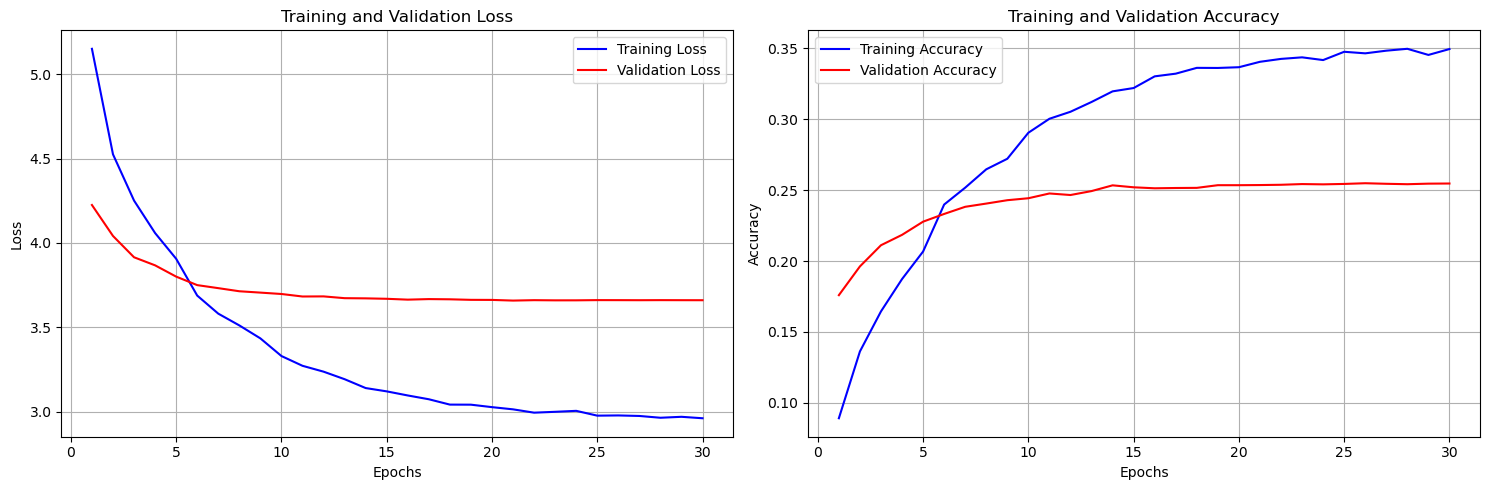

In [8]:
plot_training_curves(
    (train_losses, train_accuracies),
    (eval_losses, eval_accuracies),
)

# Evaluation metrics

In [9]:
# Load the best model weights
best_model_path = f"{MODEL_NAME}.pth"

# Load the saved model weights
model.load_state_dict(torch.load(best_model_path))
model.eval()  # Set the model to evaluation mode
print(f"Loaded best model from {best_model_path}")

# Evaluate the loaded model
val_loss, val_accuracy = evaluate(model, val_loader, criterion, device=device)
print(f"Best model - Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

Loaded best model from alexnet_pft.pth


Best model - Validation Loss: 3.6607, Validation Accuracy: 0.2546


In [10]:
top_1 = evaluate_topk(model, val_loader, k=1, device=device)
top_5 = evaluate_topk(model, val_loader, k=5, device=device)

print(f"Colormap: {COLOR_MAP}, Top-1 Accuracy: {top_1:.4f}, Top-5 Accuracy: {top_5:.4f}")

Colormap: stacked, Top-1 Accuracy: 0.2540, Top-5 Accuracy: 0.4818
